This notebook covers the "how" of professional forecasting. It demonstrates:
* **Why random splits fail** for time series (and why you must use temporal splitting).
* **Cross-validation strategies** (Expanding Window, Rolling Window, and Nested CV).
* **Metric selection** (How different metrics pick different winners).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

In standard ML, we shuffle data. In time series, this destroys temporal dependencies and causes data leakage (training on the future).

In [2]:
# Generate synthetic data with a structural break
# Simulating the "remote work" trend shift
dates = pd.date_range('2019-01-01', '2023-12-31', freq='D')
n = len(dates)
np.random.seed(42)

# Pre-shock: Steady growth
trend_pre = np.linspace(10, 20, n)
# Shock: Sudden jump in 2020 (index ~400)
shock = np.zeros(n)
shock[400:] = 30  # Structural break
# Noise
noise = np.random.normal(0, 2, n)

y_values = trend_pre + shock + noise
df = pd.DataFrame({'y': y_values}, index=dates)

Feature engineering

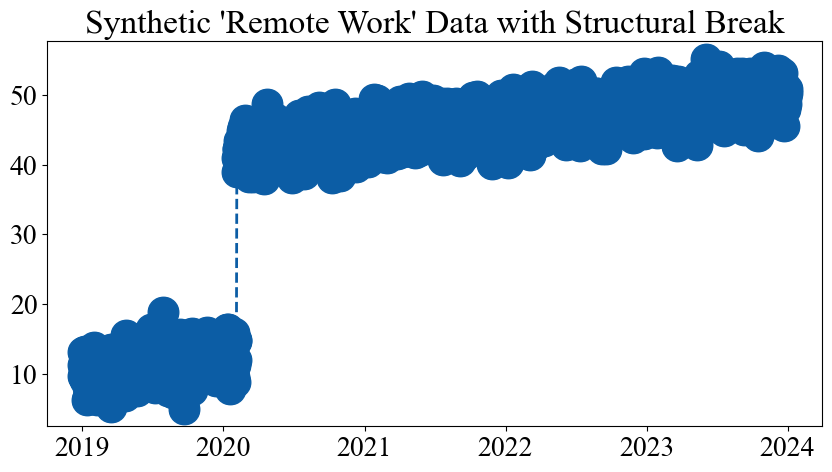

In [3]:
df['lag_1'] = df['y'].shift(1)
df.dropna(inplace=True)

X = df[['lag_1']]
y = df['y']

plt.figure(figsize=(10, 5))
plt.plot(y)
plt.title("Synthetic 'Remote Work' Data with Structural Break")
plt.show()

# Random vs. Temporal Split Experiment

We will train a Random Forest on a random split (WRONG) and a temporal split (RIGHT) and compare the MAE

In [4]:
# WRONG: Random train-test split
X_train_rand, X_test_rand, y_train_rand, y_test_rand = train_test_split(
    X, y, test_size=0.2, shuffle=True
)

# RIGHT: Temporal train-test split
split_point = int(0.8 * len(df))
X_train_temp, y_train_temp = X[:split_point], y[:split_point]
X_test_temp, y_test_temp = X[split_point:], y[split_point:]

# Fit identical models and compare results
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# 1. Random Split Training
rf_model.fit(X_train_rand, y_train_rand)
mae_random = mean_absolute_error(y_test_rand, rf_model.predict(X_test_rand))

# 2. Temporal Split Training
rf_model.fit(X_train_temp, y_train_temp)
mae_temporal = mean_absolute_error(y_test_temp, rf_model.predict(X_test_temp))

print(f"Random Split MAE (Misleading): {mae_random:.2f}")
print(f"Temporal Split MAE (Realistic): {mae_temporal:.2f}")
print(f"Difference: {((mae_temporal - mae_random) / mae_random) * 100:.1f}%")

# The random split often underestimates error because it "peeked" at future points surrounding the test points.

Random Split MAE (Misleading): 2.32
Temporal Split MAE (Realistic): 2.73
Difference: 17.7%


Cross-Validation Techniques

In [5]:
from sktime.forecasting.model_selection import ExpandingWindowSplitter, SlidingWindowSplitter
cv_expanding = ExpandingWindowSplitter(
    initial_window=100,
    step_length=20,
    fh=5  # Forecasting Horizon
)

print("--- Expanding Window Indices (First 3 folds) ---")
for i, (train_idx, test_idx) in enumerate(cv_expanding.split(y)):
    if i < 3:
        print(f"Fold {i}: Train end={train_idx[-1]}, Test range={test_idx[0]}-{test_idx[-1]}")

--- Expanding Window Indices (First 3 folds) ---
Fold 0: Train end=99, Test range=104-104
Fold 1: Train end=119, Test range=124-124
Fold 2: Train end=139, Test range=144-144


In [6]:
cv_sliding = SlidingWindowSplitter(
    window_length=100,
    step_length=20,
    fh=5
)

print("\n--- Sliding Window Indices (First 3 folds) ---")
for i, (train_idx, test_idx) in enumerate(cv_sliding.split(y)):
    if i < 3:
        print(f"Fold {i}: Train range={train_idx[0]}-{train_idx[-1]}, Test range={test_idx[0]}-{test_idx[-1]}")


--- Sliding Window Indices (First 3 folds) ---
Fold 0: Train range=0-99, Test range=104-104
Fold 1: Train range=20-119, Test range=124-124
Fold 2: Train range=40-139, Test range=144-144


Walk-Forward Validation

In [11]:
from sktime.forecasting.model_evaluation import evaluate
from sktime.forecasting.arima import ARIMA

# Define a simple forecaster
forecaster = ARIMA(order=(1, 1, 0), suppress_warnings=True)

# Note: This might take a moment to run as it trains multiple models
results = evaluate(
    forecaster=forecaster,
    y=y,
    cv=cv_sliding,
    scoring=mean_absolute_error,
    return_data=False
)

print(f"\nAverage MAE from Walk-Forward Validation: {results['test__DynamicForecastingErrorMetric'].mean():.2f}")


Average MAE from Walk-Forward Validation: 2.04


# Nested Cross-Validation

Avoiding hyperparameter overfitting by using an inner loop for tuning and an outer loop for evaluation

In [23]:
from sktime.forecasting.model_selection import ForecastingRandomizedSearchCV
from sktime.split import SingleWindowSplitter, temporal_train_test_split
from sktime.performance_metrics.forecasting import MeanAbsoluteError

# 1. Outer Split: Separate a final test set
y_train, y_test = temporal_train_test_split(y, test_size=30)

# 2. Inner Splitter for Tuning
inner_cv = SingleWindowSplitter(window_length=200, fh=10)

# 3. Define Model and Params
forecaster = ARIMA(suppress_warnings=True)
param_dist = {
    "order": [(1,1,0), (1,1,1), (2,1,0)] # Simplified for speed
}


# 4. Randomized Search using sktime's native tuner
random_search = ForecastingRandomizedSearchCV(
    forecaster=forecaster,
    cv=inner_cv,
    param_distributions=param_dist,
    n_iter=3,
    scoring=MeanAbsoluteError(), # Use sktime metric class
    random_state=42
)

In [26]:
# 5. Fit on Train
random_search.fit(y=y_train)

# 6. Unbiased Evaluation
best_model = random_search.best_forecaster_

# Generate forecast horizon
fh_index = np.arange(1, len(y_test) + 1)
y_pred = best_model.predict(fh=fh_index)

print(f"Best Params: {random_search.best_params_}")
mae = MeanAbsoluteError()
print(f"Unbiased Test MAE: {mae(y_test, y_pred):.2f}")

Best Params: {'order': (2, 1, 0)}
Unbiased Test MAE: 1.54


Performance Metrics

In [27]:
# Setup Data and Models
np.random.seed(42)
actual = np.array([100, 120, 90, 110, 95, 130, 85, 125, 105, 115])

# Model A: Consistently slightly wrong (biased)
forecast_a = actual * 0.95

# Model B: Usually perfect, one large error (outlier)
forecast_b = actual.copy().astype(float)
forecast_b[8] = 150  # The outlier

# Model C: Unbiased with normal random error
forecast_c = actual + np.random.normal(0, 8, len(actual))

# Helper function
def calculate_key_metrics(actual, forecast):
    mae = np.mean(np.abs(actual - forecast))
    rmse = np.sqrt(np.mean((actual - forecast)**2))
    mape = np.mean(np.abs((actual - forecast) / actual)) * 100
    return {'MAE': mae, 'RMSE': rmse, 'MAPE': mape}

# Calculate Results
results_df = pd.DataFrame({
    'Model A': calculate_key_metrics(actual, forecast_a),
    'Model B': calculate_key_metrics(actual, forecast_b),
    'Model C': calculate_key_metrics(actual, forecast_c)
}).T

# Rank them (1 = Best)
rankings = results_df.rank()

print("--- Model Performance ---")
print(results_df.round(2))
print("\n--- Model Rankings (1=Best) ---")
print(rankings)

--- Model Performance ---
          MAE   RMSE  MAPE
Model A  5.38   5.42  5.00
Model B  4.50  14.23  4.29
Model C  5.31   6.55  5.23

--- Model Rankings (1=Best) ---
         MAE  RMSE  MAPE
Model A  3.0   1.0   2.0
Model B  1.0   3.0   1.0
Model C  2.0   2.0   3.0


MASE (Mean Absolute Scaled Error)

In [28]:
# Formula: MAE_model / MAE_naive
# MASE Calculation Example
mae_model_c = results_df.loc['Model C', 'MAE']

# Assume the naive forecast had a MAE of 12.5 on the training set
mae_naive_train = 12.5

mase_model_c = mae_model_c / mae_naive_train
print(f"\nModel C MASE: {mase_model_c:.2f}")
print(f"Interpretation: Model C is {(1 - mase_model_c) * 100:.0f}% better than the naive baseline.")


Model C MASE: 0.42
Interpretation: Model C is 58% better than the naive baseline.
